<a name="top"></a><img src="source/SpinalHDL.png" alt="SpinalHDL based on Scala" style="width:320px;" />

  Before running Spinal HDL code, be sure to load SpinalHDL Libraries  
**Note** : This may be a little slow when the first time load, please wait a moment to download Lib from remote.)

In [ ]:
val path = System.getProperty("user.dir") + "/source/load-spinal.sc"
interp.load.module(ammonite.ops.Path(java.nio.file.FileSystems.getDefault().getPath(path)))

## Stream

The Stream interface is a simple handshake protocol to carry payload.
It could be used for example to push and pop elements into a FIFO, send requests to a UART controller, etc.
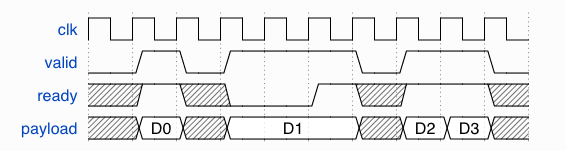
There is some examples of usage in SpinalHDL :

In [ ]:
class StreamFifo[T <: Data](dataType: T, depth: Int) extends Component {
  val io = new Bundle {
    val push = slave Stream (dataType)
    val pop = master Stream (dataType)
  }
  io.pop << io.push
}

class StreamArbiter[T <: Data](dataType: T,portCount: Int) extends Component {
  val io = new Bundle {
    val inputs = Vec(slave Stream (dataType),portCount)
    val output = master Stream (dataType)
  }
  io.inputs
}

The following code will create this logic :
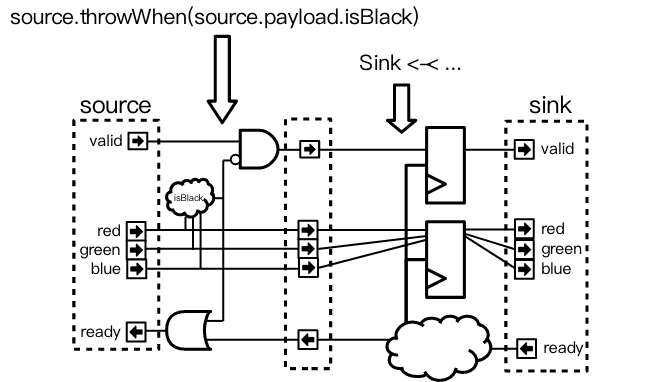

In [ ]:
case class RGB(channelWidth : Int) extends Bundle{
  val red   = UInt(channelWidth bit)
  val green = UInt(channelWidth bit)
  val blue  = UInt(channelWidth bit)

  def isBlack : Bool = red === 0 && green === 0 && blue === 0
}

class Top extends Component{
  val source = slave Stream(RGB(8))
  val sink   = master Stream(RGB(8))
  sink <-< source.throwWhen(source.payload.isBlack) 
}
showRtl(new Top)

In [ ]:
import spinal.lib._
class Top extends Component{
val streamA,streamB = Stream(Bits(8 bits))
slave(streamA)
master(streamB)
//...
val myFifo = StreamFifo(
    dataType = Bits(8 bits),
    depth    = 128)
 
myFifo.io.push << streamA
myFifo.io.pop  >> streamB
}
showRtl(new Top)

## Flow

In [ ]:
case class RGB(channelWidth: Int) extends Bundle{
  val red   = UInt(channelWidth bit)
  val green = UInt(channelWidth bit)
  val blue  = UInt(channelWidth bit)
  def isBlack : Bool = red === 0 && green === 0 && blue === 0
} 

class MyRGB extends Component{
  val source = slave  Stream(RGB(8))
  val sink   = master Stream(RGB(8))
  sink <-< source.s2mPipe
} 

class T3 extends Component{
 val a = in(UInt(8 bits))
 val b = out(UInt(8 bits))
 b := a + 133
}
showRtl(new T3)

In [ ]:
class Myflow1 extends Component{
    val source = slave  Flow(RGB(8))
    val sink   = master Flow(RGB(8))
    sink <-< source 
}

showRtl(new Myflow1)

In [ ]:
class T1 extends Component{
    val a = slave Flow(UInt(8 bits) )
    val b = master Flow(UInt())
    val tmp = a.toStream
    b := tmp.toFlow
}
showRtl(new T1)

In [ ]:
class T1 extends Component{
    val a = slave Stream(UInt(8 bits))
    val b = master Flow(UInt(8 bits) ) 
    b << a.toFlow
}
showRtl(new T1)

## Example

In [ ]:
case class FilterConfig(iqWidth: Int, 
                        tapNumbers: Int = 33,
                        hwFreq: HertzNumber = 200 MHz, 
                        sampleFreq: HertzNumber = 1.92 MHz)

case class IQ(width: Int) extends Bundle{
  val I,Q = SInt(width bits)
}

class Filter(fc: FilterConfig) extends Component{
  //val din   = slave Flow(IQ(fc.iqWidth))
  //val dout  = master Flow(IQ(fc.iqWidth))
  val din   = slave Flow(Bits(32 bits))
  val dout  = master Flow(Bits(32 bits))
  val flush = in Bool()
    
  val clockSMP = ClockDomain.external("smp")
  val clockHW = ClockDomain.external("hw")
    
  val u_fifo_in = StreamFifoCC(
      dataType = Bits(32 bits), 
      depth = 8,
      pushClock = clockSMP,
      popClock = clockDomain
  )
    
  u_fifo_in.io.push << din.toStream 
  dout << u_fifo_in.io.pop.toFlow
    
}

showRtl(new Filter(FilterConfig(8)))

In [ ]:
class IQ extends Bundle{
  val I, Q = SInt(8 bits)
}
class Filter extends Component{
    val din = slave Flow(new IQ)    
    val dout = master Stream(new IQ)
    dout << din.toStream.queue(16)
}
showRtl(new Filter)

In [ ]:
case class Color(channelWidth: Int) extends Bundle {
  val r,g,b = UInt(channelWidth bits)
}
class T3 extends Component{
  val io = new Bundle{
   val input  = in (Color(8) )
   val output = out(Color(8))
}
    io.output <> io.input
}
showRtl(new T3)

## rgb

In [ ]:
 
case class Rgb(channelWidth: Int) extends Bundle{
  val r = UInt(channelWidth bits)
  val g = UInt(channelWidth bits)
  val b = UInt(channelWidth bits)
    
  def init(x: Int): Rgb = {
      r init U(x)
      g init U(x)
      b init U(x)
      this
  }
  def clear = {
      this.r := 0
      this.g := 0
      this.b := 0
      this
  }
 // override def clone :Rgb = Rgb.asInstanceOf[this.type]
}

class T3 extends Component{
    val a = slave Flow(Rgb(8))     
    val flush = in Bool()
    val b = master Flow(Rgb(8))
    
    val retReg = Reg(cloneOf(a.payload)) init 0    
    
    when(flush){
       retReg.clear
    }.otherwise{
       retReg := a.payload
    }
    
    b.payload := retReg
    b.valid := True
 
}
showRtl(new T3)

## StreamFIFO
- readsync readyasync optional for depth > 1
- occupanccy/avalibility optinal

In [ ]:
showRtl(StreamFifo(UInt(8 bits),1))

In [ ]:
class Top extends Component{
 //val a = slave  Stream(UInt( 8 bits)) 
 //val b = master Stream(UInt(8 bits))
 //    b := a.queue(4)
    Stream(UInt(8 bits)).queue(4)
}
showRtl(new Top)

## Mem 
- `readSync`  get value next cycle
- `readAsync` get value current cycle

In [ ]:
class Top extends Component{
    val addr = in UInt(5 bits)
    val b = out UInt(8 bits)
    
    val ram = Mem(UInt(8 bits),32)
    
    b := ram.readAsync(addr) 
    //b := ram.readSync(addr) 
}
showRtl(new Top)

### Fragment

In [ ]:
class Top extends Component{
  val a = slave Flow(Fragment(UInt(8 bits)))
  val b = out UInt()
  val c = out UInt()
  b := a.payload.fragment  //
  c := a.fragment          // can be omitted
}
showRtl(new Top)

### Custom your owner bundle

In [ ]:
case class wrPort[T <: Data](val payloadType: HardType[T]) extends Bundle with IMasterSlave {
  val wr    = Bool()
  val waddr = UInt(8 bits)
  val wdata: T = payloadType()
  override def asMaster(): Unit = out(this)
  override def clone: wrPort[T] = wrPort(payloadType).asInstanceOf[this.type]
}

In [ ]:
class Top extends Component{
    val wr = slave(wrPort(Vec(SInt(8 bits), 4)))
}
showRtl(new Top)